#### Topic:        
Project 1

#### Subject:      
Explore MTA turnstile data

#### Date:         
07/05/2020

#### Names:         
Stephan Hermanides, Ryan Richbourg, Will Stith

#### Location:     
(file path)

Import standard Python modules & Jupyter Notebook configurations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns
import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

Manually scrape MTA data from their website

In [2]:
url_template = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'

# Remove comment if you want to run all 3 years of data

# dates_2017 = [170107, 170114, 170121, 170128,
#               170204, 170211, 170218, 170225,
#               170304, 170311, 170318, 170325,
#               170401, 170408, 170415, 170422, 170429,
#               170506, 170513, 170520, 170527,
#               170603, 170610, 170617, 170624,
#               170701, 170708, 170715, 170722, 170729,
#               170805, 170812, 170819, 170826,
#               170902, 170909, 170916, 170923, 170930,
#               171007, 171014, 171021, 171028,
#               171104, 171111, 171118, 171125,
#               171202, 171209, 171216, 171223, 171230] # Contains Dec 31 2016

# dates_2018 = [180106, 180113, 180120, 180127,
#               180203, 180210, 180217, 180224,
#               180303, 180310, 180317, 180324, 180331,
#               180407, 180414, 180421, 180428,
#               180505, 180512, 180519, 180526,
#               180602, 180609, 180616, 180623, 180630,
#               180707, 180714, 180721, 180728,
#               180804, 180811, 180818, 180825,
#               180901, 180908, 180915, 180922, 180929,
#               181006, 181013, 181020, 181027,
#               181103, 181110, 181117, 181124,
#               181201, 181208, 181215, 181222, 181229]

mta_dates = [190105, 190112, 190119, 190126, 
             190202, 190209, 190216, 190223, 
             190302, 190309, 190316, 190323, 190330,
             190406, 190413, 190420, 190427,
             190504, 190511, 190518, 190525,
             190601, 190608, 190615, 190622, 190629,
             190706, 190713, 190720, 190727,
             190803, 190810, 190817, 190824, 190831,
             190907, 190914, 190921, 190928,
             191005, 191012, 191019, 191026,
             191102, 191109, 191116, 191123, 191130,
             191207, 191214, 191221, 191228, 200104] # included Jan 4 2020 to capture Dec 29-31 2019

# mta_dates = dates_2017 + dates_2018 + mta_dates

raw_data = pd.concat([pd.read_csv(url_template.format(d)) for d in mta_dates])

Data Cleaning checks:

1. Clean whitespace in column names
2. Convert Date/Time columns into Datetime type
3. Remove carryover data from previous and/or next years
3. Create a unique identifier for each turnstile
4. Remove duplicate entries

In [3]:
raw_data.columns = raw_data.columns.str.rstrip()

In [4]:
raw_data["DATETIME"] = pd.to_datetime(raw_data.DATE + " " + raw_data.TIME, 
                                       format="%m/%d/%Y %H:%M:%S")

In [5]:
raw_data = raw_data[raw_data.DATETIME.dt.year == 2019].reset_index(drop=True)
# Update mask condition if other years are included in data scraping

In [6]:
raw_data["ID"] = raw_data['C/A'] + raw_data['UNIT'] + raw_data['SCP'] + raw_data['STATION']

In [7]:
raw_data.drop_duplicates(subset=["ID", "DATETIME"], inplace=True)

Because the time column isn't as neat as it first appears, let's create a function that will neatly pool observations into 4-hour timeslots and create a new 'TIMESLOT' column.

In [8]:
def get_time_slot(time):
    timestr = str(time)
    timenum = int(re.sub('[^0-9]', '', timestr))
    if 0 < timenum <= 40000:
        return 0
    elif 40000 < timenum <= 80000:
        return 1
    elif 80000 < timenum <= 120000:
        return 2
    elif 120000 < timenum <= 160000:
        return 3
    elif 160000 < timenum <= 200000:
        return 4
    else:
        return 5

In [9]:
raw_data['TIMESLOT'] = raw_data.TIME.apply(get_time_slot)

In [10]:
raw_data.TIMESLOT.value_counts()

2    1827689
1    1785321
4    1778838
3    1777057
5    1769547
0    1764759
Name: TIMESLOT, dtype: int64

**FOR TIME OF DAY ANALYSIS:** Let's now create columns which show entries and exits since the last tally, rather than cumulative entries and exits.

In [11]:
raw_data['NEWENTRIES'] = raw_data['ENTRIES'].diff()
raw_data.dropna(subset=['NEWENTRIES'], axis=0, inplace=True)

raw_data['NEWEXITS'] = raw_data['EXITS'].diff()
raw_data.dropna(subset=['NEWEXITS'], axis=0, inplace=True)

In [12]:
raw_data[['NEWENTRIES', 'NEWEXITS']].head()

,NEWENTRIES,NEWEXITS
2,41.0,45.0
3,120.0,21.0
4,146.0,41.0
5,131.0,20.0
6,22.0,5.0


Below are same functions as later, modified for time of day analysis.

In [13]:
def get_timeslot_counts_entries(row, max_counter):
    if row["NEWENTRIES"] < 0:
        # Maybe counter is reversed?
        row["NEWENTRIES"] = abs(row["NEWENTRIES"])
    if row["NEWENTRIES"] > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        row["NEWENTRIES"] = 0
    return row["NEWENTRIES"]

raw_data["NEWENTRIES"] = raw_data.apply(get_timeslot_counts_entries, axis=1, max_counter=2400)

In [14]:
def get_timeslot_counts_exits(row, max_counter):
    if row["NEWEXITS"] < 0:
        # Maybe counter is reversed?
        row["NEWEXITS"] = abs(row["NEWEXITS"])
    if row["NEWEXITS"] > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        row["NEWEXITS"] = 0
    return row["NEWEXITS"]

raw_data["NEWEXITS"] = raw_data.apply(get_timeslot_counts_exits, axis=1, max_counter=2400)

In [15]:
raw_data["TOD_TRAFFIC"] = raw_data.NEWENTRIES + raw_data.NEWEXITS
raw_data_may = raw_data[raw_data.DATETIME.dt.month == 5]
raw_data_may_weekday = raw_data_may[raw_data_may.DATETIME.dt.dayofweek < 5]
timeslot_busyness = raw_data_may.groupby(['TIMESLOT']).TOD_TRAFFIC.mean()

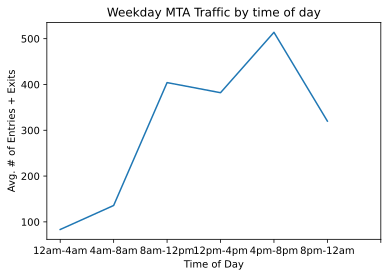

In [16]:
plt.plot(timeslot_busyness)
plt.title('Weekday MTA Traffic by time of day')
plt.xlabel('Time of Day')
plt.ylabel('Avg. # of Entries + Exits')
plt.xticks(np.arange(0,7,1), ['12am-4am','4am-8am','8am-12pm','12pm-4pm','4pm-8pm','8pm-12am'])
plt.savefig('avg_traffic_by_time_of_day_may_2019.svg');

Convert cumulative `Entry` and `Exit` numbers to daily counts

In [17]:
daily_data_by_turnstile = raw_data.groupby(['STATION','ID','DATE'])['ENTRIES', 'EXITS'].last().diff()
daily_data_by_turnstile.dropna(subset=["ENTRIES","EXITS"], axis=0, inplace=True)
daily_data_by_turnstile.reset_index(inplace=True)

In [18]:
daily_data_by_turnstile.describe()

,ENTRIES,EXITS
count,1.773479e+06,1.773479e+06
mean,1.071341e-05,8.401566e-05
std,1.791774e+07,1.580419e+07
min,-2.129137e+09,-2.110825e+09
25%,2.340000e+02,1.430000e+02
50%,7.550000e+02,4.930000e+02
75%,1.497000e+03,1.115000e+03
max,2.129102e+09,2.107588e+09


First analysis of the resulting data shows some problems
* negative values, indicating turnstile tickers that count down instead of up
* Very large values that indicate a reset of a ticker

We take the absolute values for the negative ticker data and set a limit for the maximum reasonable value of people going through a turnstile. Anything higher than this number, we replace it with the mean for the rest of the values for that turnstile.

Side note: In a smaller sample size we originally set 17280 as the turnstile daily limit (representing 1 person through a turnstile every 5 seconds for 24 hours). Based on that calculation, the summary statistics were still extremely skewed right. We updated our turnstile daily limit to 12342 (1 person every 7 seconds for 24 hours) as it made the summary statistics more reasonable. At this point it is difficult to tell whether the remaining extreme outliers are the result of erroneous turnstile ticker resets or if they are real (in which case about 15-20 stations produce the most traffic by a longshot). This real case may in fact demonstrate an 80/20 Pareto effect. 

In [19]:
def clean_daily_counts_entries(row, daily_limit):
    if row["ENTRIES"] < 0:
        # Maybe counter is reversed?
        row["ENTRIES"] = abs(row["ENTRIES"])
    if row["ENTRIES"] > daily_limit:
        # Check it again to make sure we're not still giving a counter that's too big
        row["ENTRIES"] = np.nan
    return row["ENTRIES"]

daily_data_by_turnstile["ENTRIES"] = daily_data_by_turnstile.apply(clean_daily_counts_entries, axis=1, daily_limit=12342)


In [20]:
def clean_daily_counts_exits(row, daily_limit):
    if row["EXITS"] < 0:
        # Maybe counter is reversed?
        row["EXITS"] = abs(row["EXITS"])
    if row["EXITS"] > daily_limit:
        # Check it again to make sure we're not still giving a counter that's too big
        row["EXITS"] = np.nan
    return row["EXITS"]

daily_data_by_turnstile["EXITS"] = daily_data_by_turnstile.apply(clean_daily_counts_exits, axis=1, daily_limit=12342)


In [21]:
daily_data_by_turnstile['ENTRIES'] = daily_data_by_turnstile['ENTRIES'].fillna(daily_data_by_turnstile.groupby('ID')['ENTRIES'].transform('mean'))
daily_data_by_turnstile['EXITS'] = daily_data_by_turnstile['EXITS'].fillna(daily_data_by_turnstile.groupby('ID')['EXITS'].transform('mean'))


In [22]:
daily_data_by_turnstile.describe()

,ENTRIES,EXITS
count,1.773418e+06,1.773434e+06
mean,1.020554e+03,8.153724e+02
std,9.880639e+02,9.793723e+02
min,0.000000e+00,0.000000e+00
25%,2.550000e+02,1.530000e+02
50%,7.730000e+02,5.040000e+02
75%,1.515000e+03,1.125000e+03
max,1.230100e+04,1.234000e+04


In [23]:
daily_data_by_turnstile["STATION_DAILY_TRAFFIC"] = daily_data_by_turnstile.ENTRIES + daily_data_by_turnstile.EXITS

In [24]:
daily_data_by_turnstile.to_csv('data_1sthalf2019_clean.csv')
# Update CSV name if needed for different data

### DATA CLEANING COMPLETED ABOVE

In [25]:
data = pd.read_csv('data_1sthalf2019_clean.csv')
# Update CSV name if needed for different data
data.drop(columns="Unnamed: 0", inplace=True)
data["DATETIME"] = pd.to_datetime(data["DATE"])
data['DAY_NAME'] = data.DATETIME.dt.day_name()
data['DAY_OF_WEEK'] = data.DATETIME.dt.weekday
data['WEEK_OF_YEAR'] = data.DATETIME.dt.week
data['MONTH'] = data.DATETIME.dt.month
data['YEAR'] = data.DATETIME.dt.year

Question: What is the best month of the year to canvas?

Assumption: The gala is going to be held mid-June. We want to start canvassing at least 1 month beforehand so that there is sufficient time to build awareness of the event, but no more than 4 months beforehand because people do not like to register that far in advance. Thus our time frame is February to May.

First we could look at the total amount of traffic for all NYC subway stations by month.

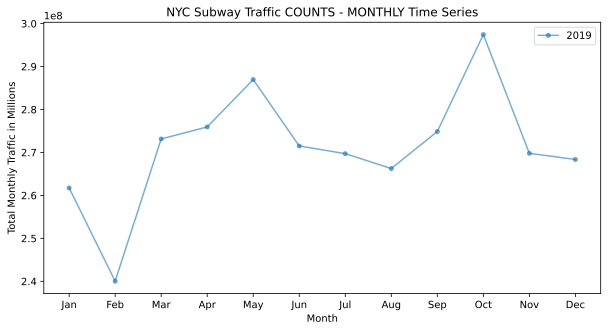

In [26]:
plt.figure(figsize=(10,5))
plt.plot(data.groupby('MONTH')['STATION_DAILY_TRAFFIC'].sum(),marker='o', markersize=4, alpha=0.6)
plt.title('NYC Subway Traffic COUNTS - MONTHLY Time Series')
plt.xlabel('Month')
plt.xticks(np.arange(1,13,1), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('Total Monthly Traffic in Millions')
plt.legend([2019])
plt.savefig('traffic_count_by_month_2019.svg');

However we should consider that February only has 28 days while March and May have 31. 

A better plot would show the average daily traffic by month. 

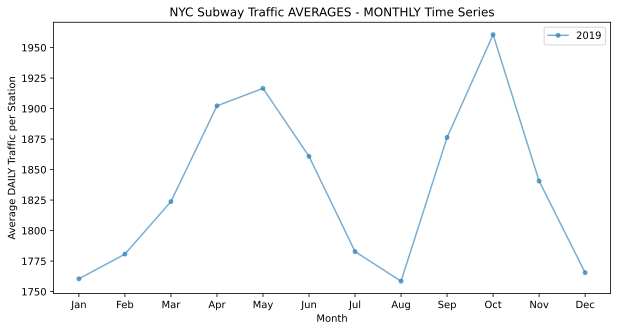

In [27]:
plt.figure(figsize=(10,5))
plt.plot(data.groupby('MONTH')['STATION_DAILY_TRAFFIC'].mean(), marker='o', markersize=4, alpha=0.6)
plt.title('NYC Subway Traffic AVERAGES - MONTHLY Time Series')
plt.xlabel('Month')
plt.xticks(np.arange(1,13,1), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('Average DAILY Traffic per Station')
plt.legend([2019])
plt.savefig('traffic_average_by_month_2019.svg');

Now it's clear that we can expect to see more people going to ride the subway on any given day in May than in February, March, or April. 

Assuming traffic volume is key to gala registrations, then it is best to focus WTWY's canvassing efforts in April and May. 

In [28]:
data_april = data[data.MONTH==4]
data_may = data[data.MONTH==5]

Now we might as well take a closer look at individual weeks in April and May.

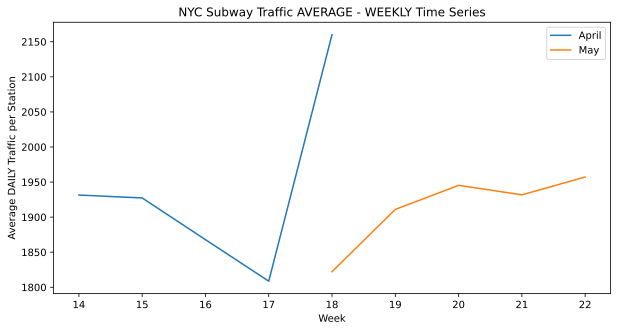

In [29]:
plt.figure(figsize=(10,5))
plt.plot(data_april.groupby('WEEK_OF_YEAR')['STATION_DAILY_TRAFFIC'].mean())
plt.plot(data_may.groupby('WEEK_OF_YEAR')['STATION_DAILY_TRAFFIC'].mean())
plt.title('NYC Subway Traffic AVERAGE - WEEKLY Time Series')
plt.xlabel('Week')
plt.ylabel('Average DAILY Traffic per Station')
plt.legend(['April', 'May'])
plt.savefig('traffic_by_week_apr_may_2019.svg');

This chart doesn't tell us very much other than April and May overlap a little bit in the 18th week of the year. 

Instead let's look at a daily time series. 

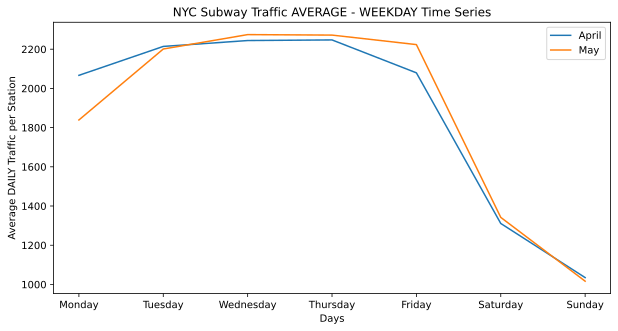

In [30]:
plt.figure(figsize=(10,5))
plt.plot(data_april.groupby('DAY_OF_WEEK')['STATION_DAILY_TRAFFIC'].mean())
plt.plot(data_may.groupby('DAY_OF_WEEK')['STATION_DAILY_TRAFFIC'].mean())
plt.title('NYC Subway Traffic AVERAGE - WEEKDAY Time Series')
plt.xlabel('Days')
plt.xticks(np.arange(0,7,1), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.ylabel('Average DAILY Traffic per Station')
plt.legend(['April', 'May'])
plt.savefig('traffic_average_day_of_week.svg');

This plot is definitely more insightful. Even during the high volume months of April and May, people primarily ride the subway Monday through Friday for commuting, and less so on Saturday and Sunday. 

In [31]:
april_ridership = data_april.groupby("STATION").STATION_DAILY_TRAFFIC.sum()
april_ridership_sorted = april_ridership.sort_values(ascending=False)
april_ridership_sorted.head(25).to_frame()

,STATION_DAILY_TRAFFIC
STATION,
34 ST-PENN STA,8.625460e+06
GRD CNTRL-42 ST,7.543727e+06
34 ST-HERALD SQ,6.393366e+06
14 ST-UNION SQ,5.413279e+06
TIMES SQ-42 ST,5.402196e+06
23 ST,5.317084e+06
42 ST-PORT AUTH,5.094476e+06
FULTON ST,4.670891e+06
86 ST,4.444760e+06


In [32]:
may_ridership = data_may.groupby("STATION").STATION_DAILY_TRAFFIC.sum()
may_ridership_sorted = may_ridership.sort_values(ascending=False)
may_ridership_sorted.head(25).to_frame()

,STATION_DAILY_TRAFFIC
STATION,
34 ST-PENN STA,8.850471e+06
GRD CNTRL-42 ST,7.649380e+06
34 ST-HERALD SQ,6.574957e+06
14 ST-UNION SQ,5.515787e+06
TIMES SQ-42 ST,5.452108e+06
23 ST,5.326238e+06
42 ST-PORT AUTH,5.258756e+06
FULTON ST,4.822924e+06
86 ST,4.602838e+06
